In [1]:
import pandas as pd
from pathlib import Path

BASE = Path(".")  # you're in test/

files = {
    ("grasp", 50):  BASE / "results_test_grasp_summary_50.csv",
    ("grasp", 100): BASE / "results_test_grasp_summary_100.csv",
    ("grasp", 200): BASE / "results_test_grasp_summary_200.csv",
    ("aco", 50):    BASE / "results_test_aco_summary_50.csv",
    ("aco", 100):   BASE / "results_test_aco_summary_100.csv",
    ("aco", 200):   BASE / "results_test_aco_summary_200.csv",
    ("genetic", 50): BASE / "results_test_genetic_summary_50.csv",
    ("genetic", 100): BASE / "results_test_genetic_summary_100.csv",
    ("genetic", 200): BASE / "results_test_genetic_summary_200.csv",
    # optional:
    # ("grasp", 1000): BASE / "results_test_grasp_summary_1000.csv",
    # ("aco", 1000):   BASE / "results_test_aco_summary_1000.csv",
    # ("genetic", 1000): BASE / "results_test_genetic_summary_1000.csv",
}

dfs = {}
for (alg, n), fp in files.items():
    assert fp.exists(), f"Missing: {fp}"
    df = pd.read_csv(fp)
    df["alg"] = alg
    df["n"] = n
    dfs[(alg, n)] = df

# quick check columns
for k, df in dfs.items():
    print(k, df.columns.tolist())


('grasp', 50) ['instance', 'n', 'obj_mean', 'obj_std', 'obj_min', 'runtime_mean', 'runtime_max', 'fairness_mean', 'alg']
('grasp', 100) ['instance', 'n', 'obj_mean', 'obj_std', 'obj_min', 'runtime_mean', 'runtime_max', 'fairness_mean', 'alg']
('grasp', 200) ['instance', 'n', 'obj_mean', 'obj_std', 'obj_min', 'runtime_mean', 'runtime_max', 'fairness_mean', 'alg']
('aco', 50) ['instance', 'n', 'obj_mean', 'obj_std', 'obj_min', 'runtime_mean', 'runtime_max', 'fairness_mean', 'alg']
('aco', 100) ['instance', 'n', 'obj_mean', 'obj_std', 'obj_min', 'runtime_mean', 'runtime_max', 'fairness_mean', 'alg']
('aco', 200) ['instance', 'n', 'obj_mean', 'obj_std', 'obj_min', 'runtime_mean', 'runtime_max', 'fairness_mean', 'alg']
('genetic', 50) ['instance', 'n', 'obj_mean', 'obj_std', 'obj_min', 'runtime_mean', 'runtime_max', 'fairness_mean', 'alg']
('genetic', 100) ['instance', 'n', 'obj_mean', 'obj_std', 'obj_min', 'runtime_mean', 'runtime_max', 'fairness_mean', 'alg']
('genetic', 200) ['instance',

In [3]:
def keep_cols(df):
    # keep only what we need, tolerate extra columns
    want = ["instance", "n", "obj_mean", "obj_std", "runtime_mean", "runtime_max", "fairness_mean", "alg"]
    missing = [c for c in want if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns {missing} in df with columns {df.columns.tolist()}")
    return df[want].copy()

all_df = pd.concat([keep_cols(df) for df in dfs.values()], ignore_index=True)

wide = (all_df
        .pivot_table(index=["n","instance"], columns="alg",
                     values=["obj_mean","obj_std","runtime_mean","runtime_max","fairness_mean"])
        .reset_index())

# flatten multiindex columns
wide.columns = ["_".join([c for c in col if c]) for col in wide.columns.to_flat_index()]

# improvement: (grasp - aco) / grasp * 100  (positive => ACO better, since lower obj)
wide["obj_improvement_pct_aco"] = 100.0 * (wide["obj_mean_grasp"] - wide["obj_mean_aco"]) / wide["obj_mean_grasp"]
wide["obj_improvement_pct_genetic"] = 100.0 * (wide["obj_mean_grasp"] - wide["obj_mean_genetic"]) / wide["obj_mean_grasp"]

wide.head()


,n,instance,fairness_mean_aco,fairness_mean_genetic,fairness_mean_grasp,obj_mean_aco,obj_mean_genetic,obj_mean_grasp,obj_std_aco,obj_std_genetic,obj_std_grasp,runtime_max_aco,runtime_max_genetic,runtime_max_grasp,runtime_mean_aco,runtime_mean_genetic,runtime_mean_grasp,obj_improvement_pct_aco,obj_improvement_pct_genetic
0,50,instance31_nreq50_nveh2_gamma50,0.988521,0.974743,0.988283,2654.297773,2226.955171,3046.703940,4.793458e-13,133.056164,52.234686,2.342169,2.561,0.024932,2.041939,0.4235,0.009236,12.879695,26.906086
1,50,instance41_nreq50_nveh2_gamma45,0.777385,0.979950,0.962495,2081.477248,1806.513181,2438.685826,0.000000e+00,71.373161,54.446266,2.014241,0.219,0.005582,2.008671,0.1924,0.004965,14.647585,25.922677
2,50,instance46_nreq50_nveh2_gamma47,0.955726,0.986946,0.967589,2583.631269,2048.363030,2753.201336,9.063523e-01,66.949972,97.595148,2.017351,0.196,0.004982,2.008255,0.1775,0.004629,6.159014,25.600682
3,50,instance51_nreq50_nveh2_gamma45,0.724262,0.965540,0.953466,2030.736298,1807.116799,2606.543126,0.000000e+00,50.091882,66.434977,2.015616,0.208,0.010044,2.008915,0.1703,0.005660,22.090823,30.669983
4,50,instance56_nreq50_nveh2_gamma43,0.774948,0.975056,0.979667,2135.927721,1926.954518,2658.248713,4.793458e-13,137.352073,60.412935,2.012187,0.217,0.017889,2.007570,0.1592,0.007581,19.649064,27.510375


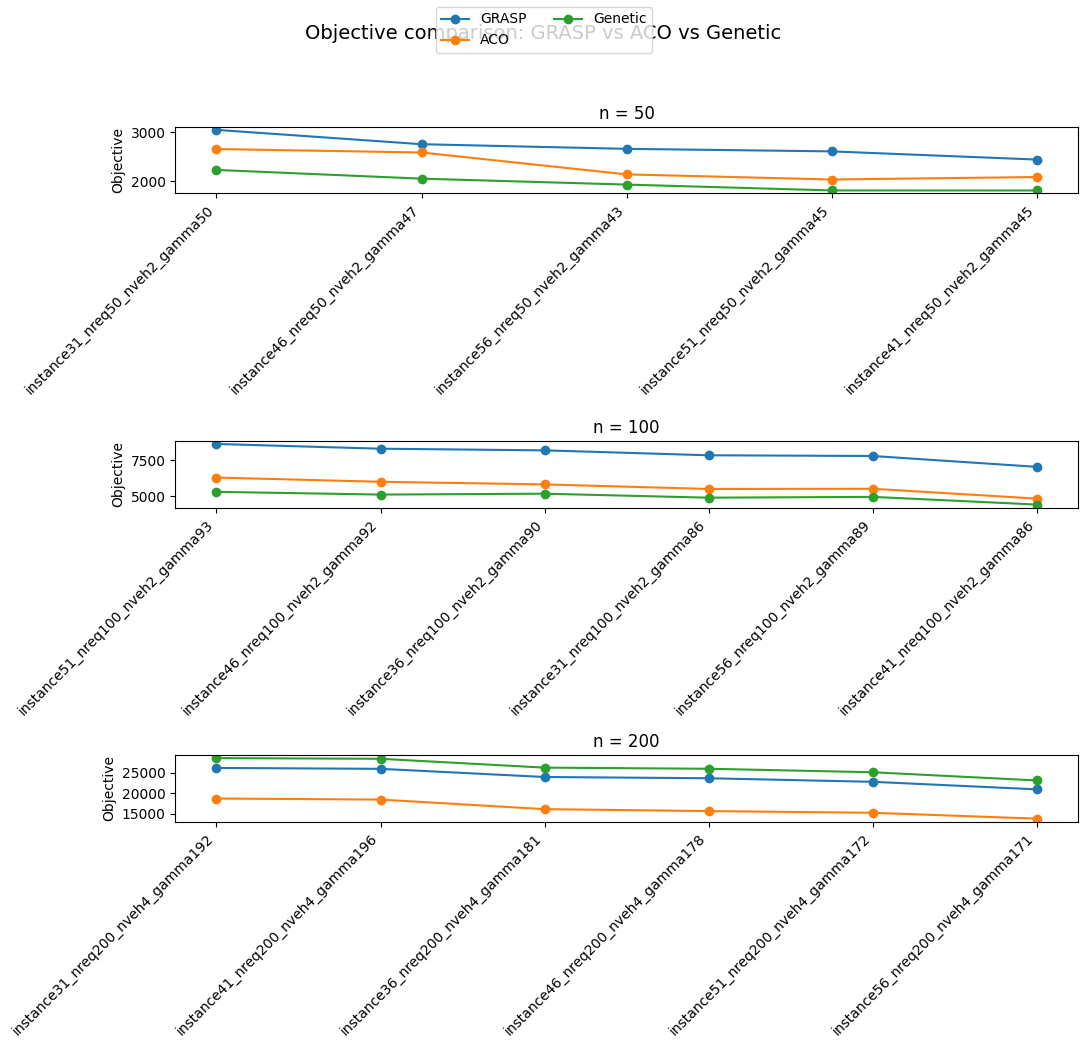

In [4]:
import matplotlib.pyplot as plt

ns = sorted(wide["n"].unique())

fig, axes = plt.subplots(
    nrows=len(ns),
    ncols=1,
    figsize=(11, 3.5 * len(ns)),
    sharex=False
)

# if only one n, axes is not a list
if len(ns) == 1:
    axes = [axes]

for ax, n in zip(axes, ns):
    sub = wide[wide["n"] == n].copy()
    sub = sub.sort_values("obj_mean_grasp", ascending=False)

    x = range(len(sub))

    ax.plot(x, sub["obj_mean_grasp"], marker="o", label="GRASP")
    ax.plot(x, sub["obj_mean_aco"], marker="o", label="ACO")
    ax.plot(x, sub["obj_mean_genetic"], marker="o", label="Genetic")

    ax.set_title(f"n = {n}")
    ax.set_ylabel("Objective")

    ax.set_xticks(x)
    ax.set_xticklabels(sub["instance"], rotation=45, ha="right")

# one legend for entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2)

fig.suptitle("Objective comparison: GRASP vs ACO vs Genetic", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


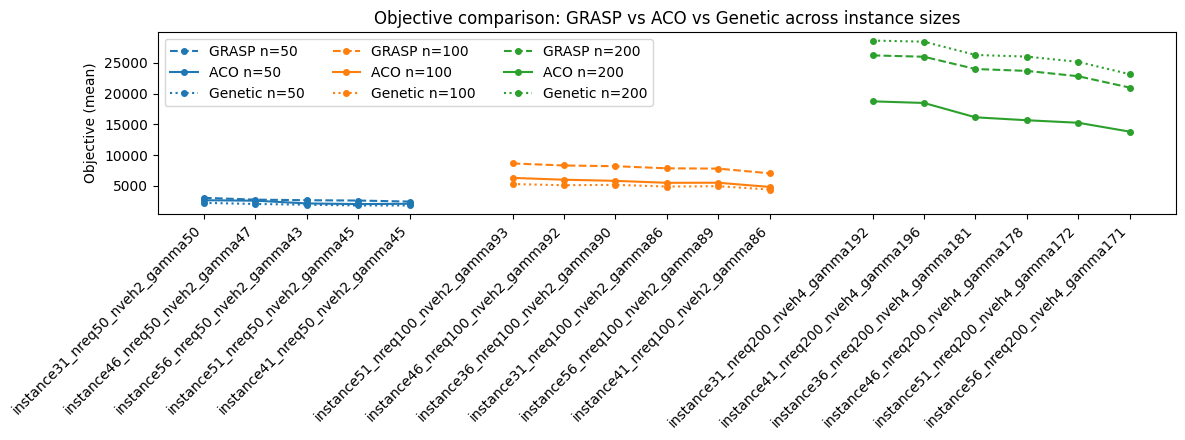

In [8]:
import matplotlib.pyplot as plt

colors = {
    50: "tab:blue",
    100: "tab:orange",
    200: "tab:green"
}

plt.figure(figsize=(12, 4.5))

x_offset = 0
xticks = []
xtick_labels = []

for n in sorted(wide["n"].unique()):
    sub = wide[wide["n"] == n].copy()
    sub = sub.sort_values("obj_mean_grasp", ascending=False)

    x = range(x_offset, x_offset + len(sub))

    # GRASP
    plt.plot(
        x,
        sub["obj_mean_grasp"],
        linestyle="--",
        marker="o",
        markersize=4,
        color=colors[n],
        label=f"GRASP n={n}"
    )

    # ACO
    plt.plot(
        x,
        sub["obj_mean_aco"],
        linestyle="-",
        marker="o",
        markersize=4,
        color=colors[n],
        label=f"ACO n={n}"
    )

    # Genetic
    plt.plot(
        x,
        sub["obj_mean_genetic"],
        linestyle=":",
        marker="o",
        markersize=4,
        color=colors[n],
        label=f"Genetic n={n}"
    )

    xticks.extend(x)
    xtick_labels.extend(sub["instance"])

    x_offset += len(sub) + 1  # spacing between groups

plt.xticks(xticks, xtick_labels, rotation=45, ha="right")
plt.ylabel("Objective (mean)")
plt.title("Objective comparison: GRASP vs ACO vs Genetic across instance sizes")

plt.legend(ncol=3)
plt.tight_layout()
plt.show()


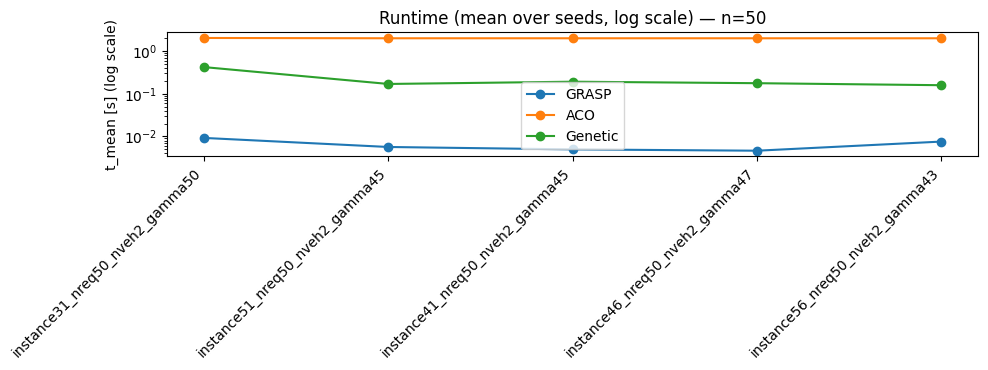

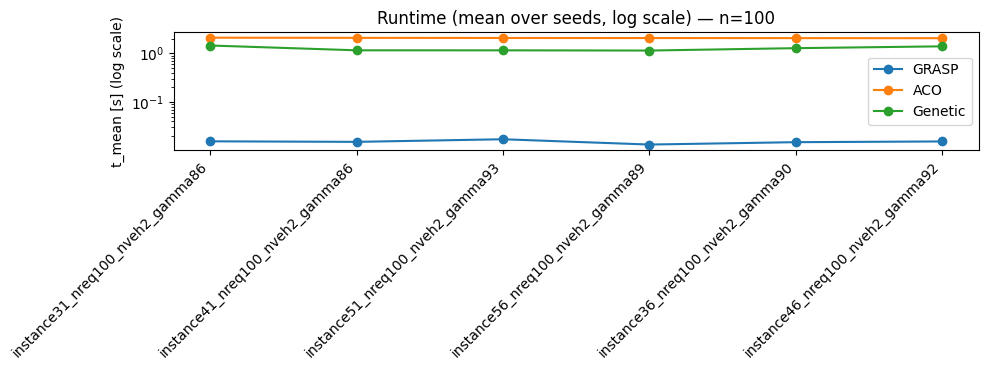

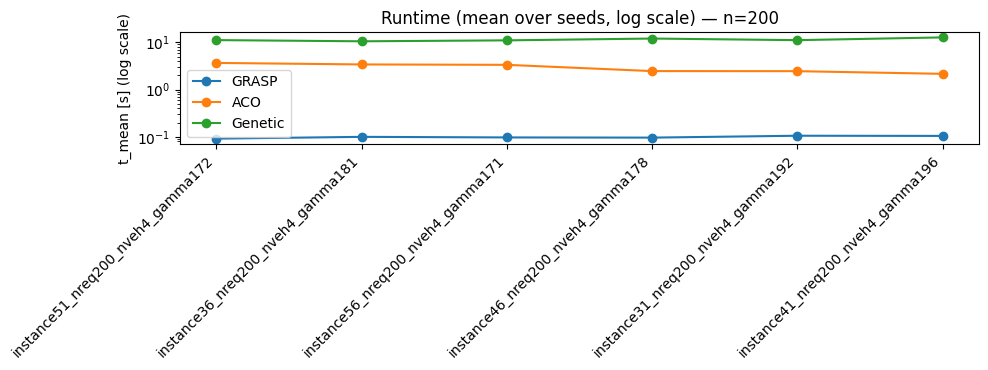

In [12]:
for n in sorted(wide["n"].unique()):
    sub = wide[wide["n"] == n].copy()
    sub = sub.sort_values("runtime_mean_aco", ascending=False)

    x = range(len(sub))
    plt.figure(figsize=(10, 3.8))
    plt.plot(x, sub["runtime_mean_grasp"], marker="o", label="GRASP")
    plt.plot(x, sub["runtime_mean_aco"], marker="o", label="ACO")
    plt.plot(x, sub["runtime_mean_genetic"], marker="o", label="Genetic")
    plt.yscale("log")
    plt.xticks(x, sub["instance"], rotation=45, ha="right")
    plt.ylabel("t_mean [s] (log scale)")
    plt.title(f"Runtime (mean over seeds, log scale) — n={n}")
    plt.legend()
    plt.tight_layout()
    plt.show()


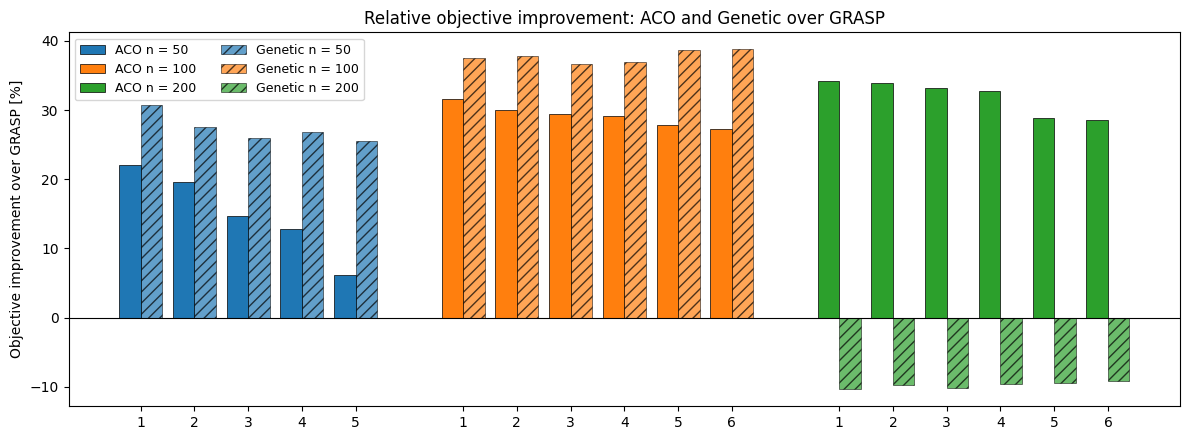

In [20]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 4.5))

colors = {
    50: "tab:blue",
    100: "tab:orange",
    200: "tab:green"
}

x_pos = 0
xticks = []
xtick_labels = []

bar_width = 0.4

for n in sorted(wide["n"].unique()):
    sub = (
        wide[wide["n"] == n]
        .copy()
        .sort_values("obj_improvement_pct_aco", ascending=False)
    )

    x = np.arange(len(sub)) + x_pos

    # ACO bars (solid fill)
    plt.bar(
        x - bar_width/2,
        sub["obj_improvement_pct_aco"],
        width=bar_width,
        color=colors[n],
        label=f"ACO n = {n}",
        edgecolor='black',
        linewidth=0.5
    )
    
    # Genetic bars (hatched pattern)
    plt.bar(
        x + bar_width/2,
        sub["obj_improvement_pct_genetic"],
        width=bar_width,
        color=colors[n],
        label=f"Genetic n = {n}",
        hatch='///',
        edgecolor='black',
        linewidth=0.5,
        alpha=0.7
    )

    xticks.extend(x)
    xtick_labels.extend([f"{i+1}" for i in range(len(sub))])

    x_pos += len(sub) + 1  # gap between n groups

plt.axhline(0, color="black", linewidth=0.8)

plt.xticks(xticks, xtick_labels)
plt.ylabel("Objective improvement over GRASP [%]")
plt.title("Relative objective improvement: ACO and Genetic over GRASP")

# Reorder legend: ACO first column, Genetic second column
handles, labels = plt.gca().get_legend_handles_labels()
# Reorder to have ACO (indices 0,2,4) in first column, Genetic (1,3,5) in second
order = [0, 2, 4, 1, 3, 5]  # ACO n=50, ACO n=100, Genetic n=50, Genetic n=100, ACO n=200, Genetic n=200
plt.legend([handles[i] for i in order], [labels[i] for i in order], ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


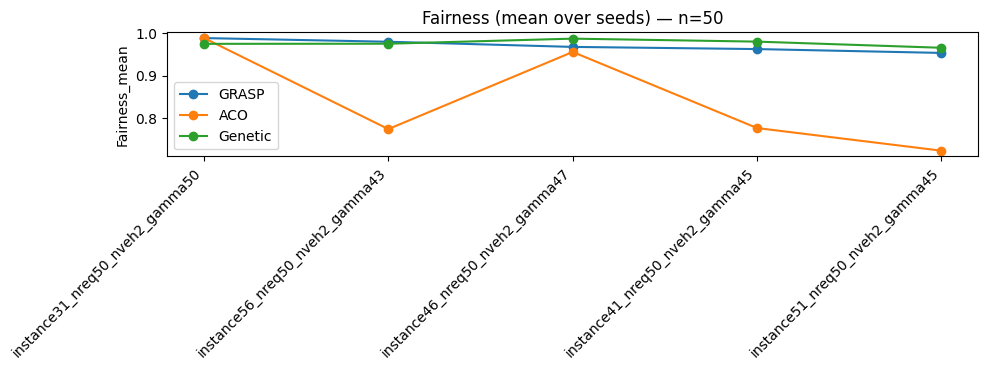

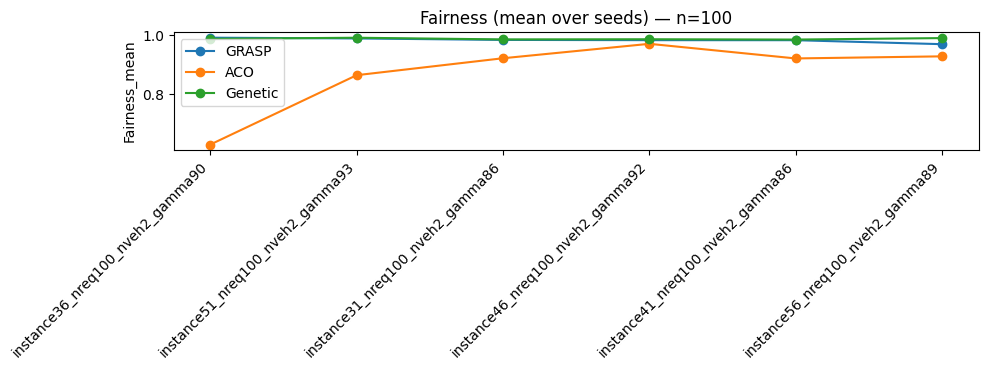

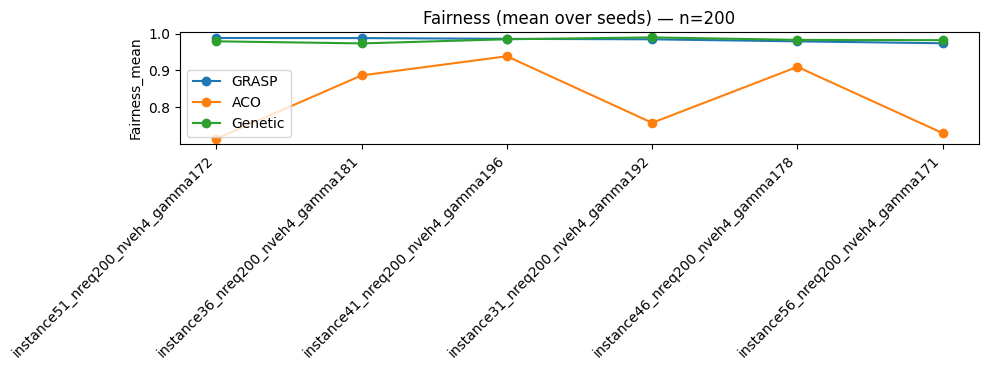

In [23]:
for n in sorted(wide["n"].unique()):
    sub = wide[wide["n"] == n].copy()
    sub = sub.sort_values("fairness_mean_grasp", ascending=False)

    x = range(len(sub))
    plt.figure(figsize=(10, 3.8))
    plt.plot(x, sub["fairness_mean_grasp"], marker="o", label="GRASP")
    plt.plot(x, sub["fairness_mean_aco"], marker="o", label="ACO")
    plt.plot(x, sub["fairness_mean_genetic"], marker="o", label="Genetic")
    plt.xticks(x, sub["instance"], rotation=45, ha="right")
    plt.ylabel("Fairness_mean")
    plt.title(f"Fairness (mean over seeds) — n={n}")
    plt.legend()
    plt.tight_layout()
    plt.show()
